In [1]:
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns
pd.set_option('display.max_columns',100)


In [3]:
logs = pd.read_csv('data/nonpublic/logs-4300459-2021.csv',parse_dates=['timecreated'])
del logs['ip']
logs[:3]

,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid
0,1656410674,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,57309,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-15 20:23:04,web,NaN
1,1654886276,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,12720,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-02 14:03:13,web,NaN
2,1654886263,\mod_chat\event\course_module_viewed,mod_chat,viewed,course_module,chat,4973.0,r,2,5552661,70,3074106,12720,79580,NaN,0,N;,2021-02-02 14:03:08,web,NaN


In [62]:
logs[logs['component'] == 'core']

,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid
0,1656410674,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,57309,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-15 20:23:04,web,NaN
1,1654886276,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,12720,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-02 14:03:13,web,NaN
3,1654886255,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,12720,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-02 14:03:04,web,NaN
4,1654886258,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,12720,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-02 14:03:04,web,NaN
7,1654602407,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,136457,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:7;}",2021-01-31 12:35:56,web,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51868,1508295675,\core\event\course_section_created,core,created,course_section,course_sections,6006210.0,c,1,5498136,50,79580,6,79580,NaN,0,"a:1:{s:10:""sectionnum"";i:7;}",2020-08-02 17:10:31,web,NaN
51869,1508295676,\core\event\course_section_created,core,created,course_section,course_sections,6006211.0,c,1,5498136,50,79580,6,79580,NaN,0,"a:1:{s:10:""sectionnum"";i:8;}",2020-08-02 17:10:31,web,NaN
51870,1508295677,\core\event\course_section_created,core,created,course_section,course_sections,6006212.0,c,1,5498136,50,79580,6,79580,NaN,0,"a:1:{s:10:""sectionnum"";i:9;}",2020-08-02 17:10:31,web,NaN
51871,1508295678,\core\event\course_section_created,core,created,course_section,course_sections,6006213.0,c,1,5498136,50,79580,6,79580,NaN,0,"a:1:{s:10:""sectionnum"";i:10;}",2020-08-02 17:10:31,web,NaN


In [61]:
logs.query("component == 'core'")

,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid
0,1656410674,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,57309,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-15 20:23:04,web,NaN
1,1654886276,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,12720,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-02 14:03:13,web,NaN
3,1654886255,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,12720,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-02 14:03:04,web,NaN
4,1654886258,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,12720,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-02 14:03:04,web,NaN
7,1654602407,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,136457,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:7;}",2021-01-31 12:35:56,web,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51868,1508295675,\core\event\course_section_created,core,created,course_section,course_sections,6006210.0,c,1,5498136,50,79580,6,79580,NaN,0,"a:1:{s:10:""sectionnum"";i:7;}",2020-08-02 17:10:31,web,NaN
51869,1508295676,\core\event\course_section_created,core,created,course_section,course_sections,6006211.0,c,1,5498136,50,79580,6,79580,NaN,0,"a:1:{s:10:""sectionnum"";i:8;}",2020-08-02 17:10:31,web,NaN
51870,1508295677,\core\event\course_section_created,core,created,course_section,course_sections,6006212.0,c,1,5498136,50,79580,6,79580,NaN,0,"a:1:{s:10:""sectionnum"";i:9;}",2020-08-02 17:10:31,web,NaN
51871,1508295678,\core\event\course_section_created,core,created,course_section,course_sections,6006213.0,c,1,5498136,50,79580,6,79580,NaN,0,"a:1:{s:10:""sectionnum"";i:10;}",2020-08-02 17:10:31,web,NaN


In [64]:
filtered = logs.query("userid != 6 & userid != -1")
clicks = filtered.groupby('userid')['id'].count()
clicks.sort_values(ascending=False)

userid
44980     1353
26462     1277
170110    1257
78746     1252
253119    1246
          ... 
57257        2
6401         1
251813       1
288579       1
307871       1
Name: id, Length: 66, dtype: int64

In [67]:
filtered

,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid
0,1656410674,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,57309,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-15 20:23:04,web,NaN
1,1654886276,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,12720,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-02 14:03:13,web,NaN
2,1654886263,\mod_chat\event\course_module_viewed,mod_chat,viewed,course_module,chat,4973.0,r,2,5552661,70,3074106,12720,79580,NaN,0,N;,2021-02-02 14:03:08,web,NaN
3,1654886255,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,12720,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-02 14:03:04,web,NaN
4,1654886258,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,12720,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-02 14:03:04,web,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51678,1508445578,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,76596,79580,NaN,0,N;,2020-08-03 00:25:29,web,NaN
51679,1508445570,\mod_forum\event\course_module_viewed,mod_forum,viewed,course_module,forum,158810.0,r,2,5498137,70,3031266,76596,79580,NaN,0,N;,2020-08-03 00:25:26,web,NaN
51680,1508445554,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,76596,79580,NaN,0,N;,2020-08-03 00:25:22,web,NaN
51683,1508354579,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,253119,79580,NaN,0,N;,2020-08-02 21:20:49,web,NaN


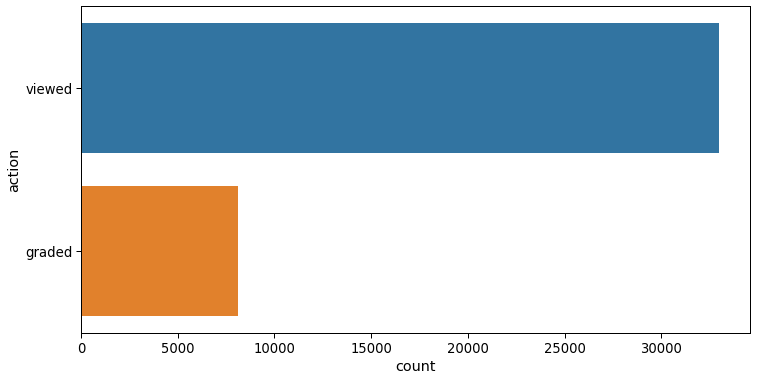

In [77]:
plt.figure(figsize=(12,6))
sns.set_context('paper',font_scale=1.5)
ax = sns.countplot(data=logs,y='action',order=['viewed','graded'])


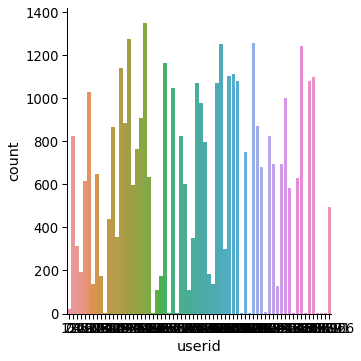

In [79]:
sns.catplot(data=filtered,x='userid', kind='count')

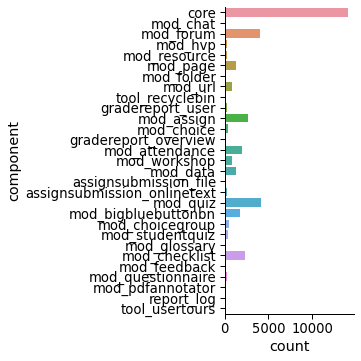

In [80]:
sns.catplot(data=filtered,y='component', kind='count')

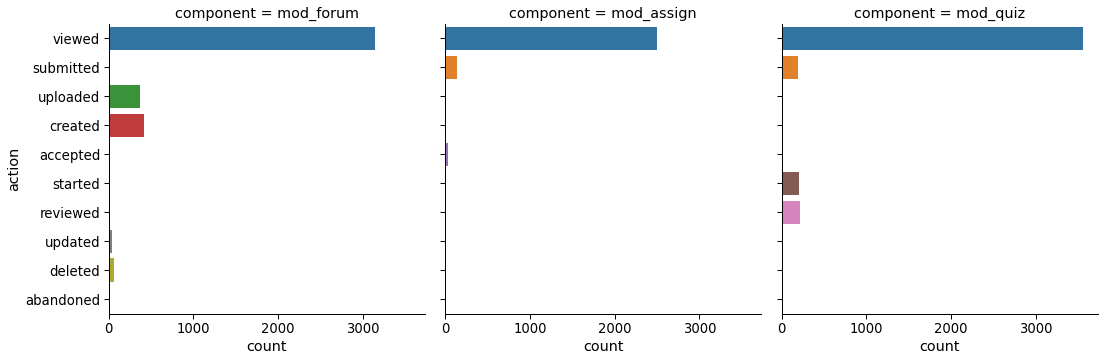

In [87]:
sns.catplot(data=filtered.query("component in ['mod_forum','mod_quiz','mod_assign']"),y='action',col='component',col_wrap=4,kind='count')

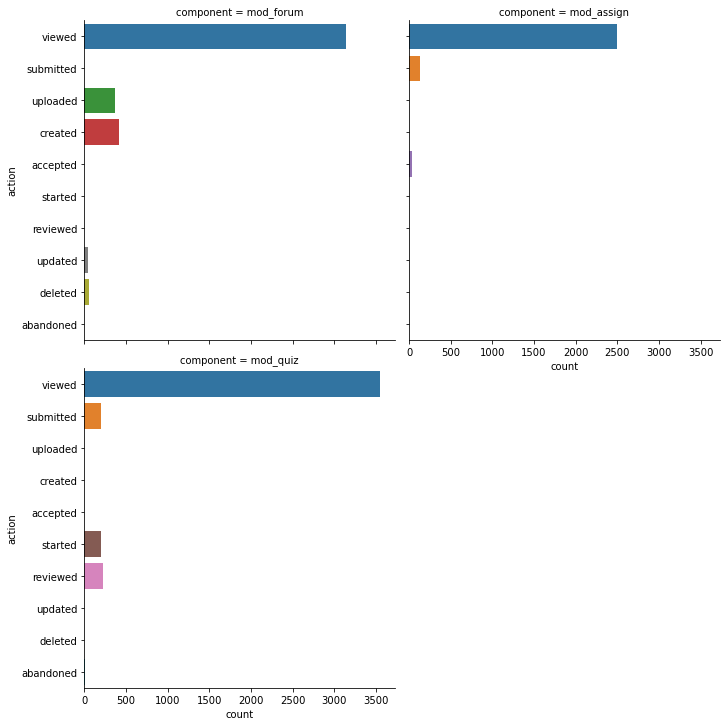

In [40]:
sns.catplot(data=filtered.query("component in ['mod_forum','mod_quiz','mod_assign']"),
            y='action',col='component', col_wrap=2, kind='count')

In [89]:
logs[:3]

,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid
0,1656410674,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,57309,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-15 20:23:04,web,NaN
1,1654886276,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,12720,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-02 14:03:13,web,NaN
2,1654886263,\mod_chat\event\course_module_viewed,mod_chat,viewed,course_module,chat,4973.0,r,2,5552661,70,3074106,12720,79580,NaN,0,N;,2021-02-02 14:03:08,web,NaN


In [5]:
logs.query("userid == 0")

,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid
107,1649692098,\core\event\capability_assigned,core,assigned,capability,role_capabilities,1.0,u,0,5524847,70,3051933,0,79580,NaN,0,"a:3:{s:10:""capability"";s:23:""moodle/question:m...",2020-12-27 07:16:48,cli,NaN
108,1649692099,\core\event\capability_assigned,core,assigned,capability,role_capabilities,1.0,u,0,5524847,70,3051933,0,79580,NaN,0,"a:3:{s:10:""capability"";s:30:""moodle/question:m...",2020-12-27 07:16:48,cli,NaN
109,1649691993,\core\event\capability_assigned,core,assigned,capability,role_capabilities,3.0,u,0,5524847,70,3051933,0,79580,NaN,0,"a:3:{s:10:""capability"";s:23:""moodle/question:m...",2020-12-27 07:16:33,cli,NaN
110,1649691994,\core\event\capability_assigned,core,assigned,capability,role_capabilities,3.0,u,0,5524847,70,3051933,0,79580,NaN,0,"a:3:{s:10:""capability"";s:30:""moodle/question:m...",2020-12-27 07:16:33,cli,NaN
111,1649689612,\core\event\capability_assigned,core,assigned,capability,role_capabilities,11.0,u,0,5524847,70,3051933,0,79580,NaN,0,"a:3:{s:10:""capability"";s:24:""moodle/question:v...",2020-12-27 07:11:18,cli,NaN
112,1649689613,\core\event\capability_assigned,core,assigned,capability,role_capabilities,11.0,u,0,5524847,70,3051933,0,79580,NaN,0,"a:3:{s:10:""capability"";s:24:""moodle/question:e...",2020-12-27 07:11:18,cli,NaN
113,1649689614,\core\event\capability_unassigned,core,unassigned,capability,role_capabilities,11.0,u,0,5524847,70,3051933,0,79580,NaN,0,"a:1:{s:10:""capability"";s:23:""moodle/question:e...",2020-12-27 07:11:18,cli,NaN
114,1649689602,\core\event\capability_assigned,core,assigned,capability,role_capabilities,1.0,u,0,5524847,70,3051933,0,79580,NaN,0,"a:3:{s:10:""capability"";s:23:""moodle/question:v...",2020-12-27 07:11:17,cli,NaN
115,1649689603,\core\event\capability_assigned,core,assigned,capability,role_capabilities,1.0,u,0,5524847,70,3051933,0,79580,NaN,0,"a:3:{s:10:""capability"";s:23:""moodle/question:e...",2020-12-27 07:11:17,cli,NaN
116,1649689604,\core\event\capability_assigned,core,assigned,capability,role_capabilities,3.0,u,0,5524847,70,3051933,0,79580,NaN,0,"a:3:{s:10:""capability"";s:22:""moodle/question:u...",2020-12-27 07:11:17,cli,NaN


In [10]:
logs['component'].value_counts()

core                           24202
mod_forum                       4994
mod_quiz                        4281
mod_assign                      3412
mod_checklist                   2460
mod_attendance                  2061
mod_bigbluebuttonbn             1967
mod_data                        1502
mod_page                        1346
mod_url                          954
mod_workshop                     933
mod_choicegroup                  546
mod_studentquiz                  452
mod_choice                       427
mod_questionnaire                320
gradereport_user                 300
mod_resource                     299
mod_hvp                          273
assignsubmission_onlinetext      270
mod_chat                         242
mod_folder                       186
mod_feedback                     155
assignsubmission_file            124
mod_glossary                      37
gradereport_grader                32
tool_recyclebin                   26
gradereport_overview              24
m

In [26]:
logs['component'].unique()

False

In [36]:
logs[logs['component'] == 'mod_quiz']

,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid
1006,1641540995,\mod_quiz\event\course_module_viewed,mod_quiz,viewed,course_module,quiz,93089.0,r,2,5524821,70,3051907,172695,79580,NaN,0,N;,2020-12-12 22:41:46,ws,NaN
1007,1641540284,\mod_quiz\event\course_module_viewed,mod_quiz,viewed,course_module,quiz,93087.0,r,2,5524743,70,3051829,172695,79580,NaN,0,N;,2020-12-12 22:40:31,ws,NaN
1008,1641539653,\mod_quiz\event\course_module_viewed,mod_quiz,viewed,course_module,quiz,93086.0,r,2,5524731,70,3051817,172695,79580,NaN,0,N;,2020-12-12 22:39:38,ws,NaN
1338,1641499209,\mod_quiz\event\course_module_viewed,mod_quiz,viewed,course_module,quiz,93089.0,r,2,5524821,70,3051907,42046,79580,NaN,0,N;,2020-12-12 21:28:08,web,NaN
1782,1641184864,\mod_quiz\event\attempt_submitted,mod_quiz,submitted,attempt,quiz_attempts,3523568.0,u,2,5524758,70,3051844,2,79580,77494.0,0,"a:2:{s:11:""submitterid"";N;s:6:""quizid"";s:5:""93...",2020-12-12 11:03:09,cli,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50558,1513449287,\mod_quiz\event\attempt_viewed,mod_quiz,viewed,attempt,quiz_attempts,2773231.0,r,2,5524731,70,3051817,6,79580,6.0,0,"a:1:{s:6:""quizid"";s:5:""93086"";}",2020-08-16 23:45:18,web,NaN
50559,1513448788,\mod_quiz\event\attempt_viewed,mod_quiz,viewed,attempt,quiz_attempts,2773231.0,r,2,5524731,70,3051817,6,79580,6.0,0,"a:1:{s:6:""quizid"";s:5:""93086"";}",2020-08-16 23:44:35,web,NaN
50560,1513448709,\mod_quiz\event\attempt_preview_started,mod_quiz,started,attempt_preview,quiz_attempts,2773231.0,r,1,5524731,70,3051817,6,79580,6.0,0,"a:1:{s:6:""quizid"";s:5:""93086"";}",2020-08-16 23:44:23,web,NaN
50561,1513448712,\mod_quiz\event\attempt_viewed,mod_quiz,viewed,attempt,quiz_attempts,2773231.0,r,2,5524731,70,3051817,6,79580,6.0,0,"a:1:{s:6:""quizid"";s:5:""93086"";}",2020-08-16 23:44:23,web,NaN


In [52]:
logs[:3]

,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid
0,1656410674,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,57309,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-15 20:23:04,web,NaN
1,1654886276,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,12720,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-02 14:03:13,web,NaN
2,1654886263,\mod_chat\event\course_module_viewed,mod_chat,viewed,course_module,chat,4973.0,r,2,5552661,70,3074106,12720,79580,NaN,0,N;,2021-02-02 14:03:08,web,NaN


In [63]:
def clicks(logs):
    'returns number of clicks'
    return len(logs)

def nviews(logs):
    v = logs.query("action == 'viewed'")
    return len(v)

def nactions(logs,actions = ['viewed'],components = []):
    'returns number of logs, filtered by actions and components'
    if not components:
        components = logs['component'].unique()
    return len(logs.query("action in @actions & component in @components"))

def fez_questionario(logs):
    return nactions(logs,actions = ['submitted'],components = ['mod_quiz'])
    
views = logs.groupby('userid').apply(nactions,components=[])
#views

In [69]:
fez_questionario(logs)

200

In [76]:
views = logs.groupby('userid').apply(nviews)
subquizs = logs.groupby('userid').apply(fez_questionario)
views*subquizs

userid
-1            0
 0            0
 2           96
 6            0
 1170       440
           ... 
 276251    4465
 288579       0
 295092       0
 307871       0
 307966     421
Length: 68, dtype: int64

<AxesSubplot:ylabel='userid'>

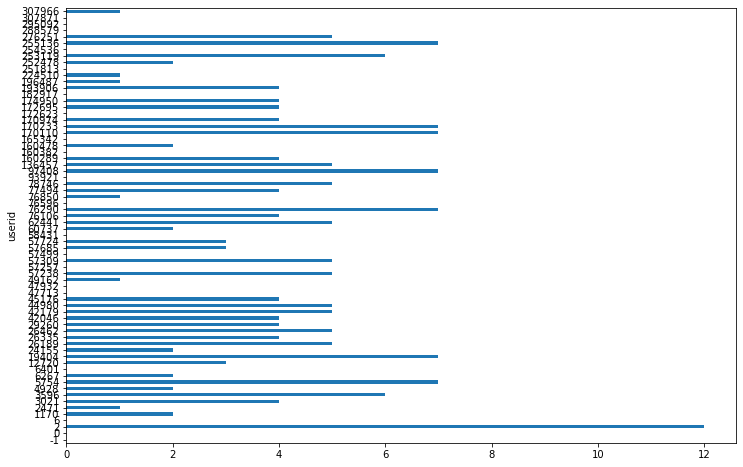

In [72]:
fig = plt.figure(figsize=(12,8))
logs.groupby('userid').apply(fez_questionario).plot(kind='barh')

In [51]:
logs.groupby('userid').apply(fez_questionario)

userid
-1          0
 0          0
 2         12
 6          0
 1170       2
           ..
 276251     5
 288579     0
 295092     0
 307871     0
 307966     1
Length: 68, dtype: int64

<AxesSubplot:ylabel='userid'>

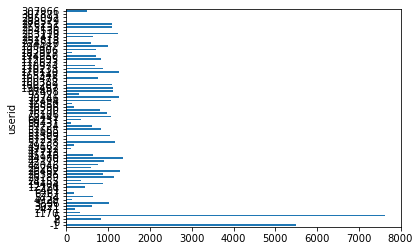

In [23]:
(clicks + views).plot(kind='barh')

In [121]:
logs.apply(indicador)

id                   51873
eventname            51873
component            51873
action               51873
target               51873
objecttable          51873
objectid             51873
crud                 51873
edulevel             51873
contextid            51873
contextlevel         51873
contextinstanceid    51873
userid               51873
courseid             51873
relateduserid        51873
anonymous            51873
other                51873
timecreated          51873
origin               51873
realuserid           51873
dtype: int64